In [2]:
import pandas_datareader.data as web
import datetime
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import math
import time
from matplotlib.pyplot import figure
import mibian
import datetime
#import pyspark
#from pyspark import SparkContext
#sc = SparkContext(master = 'local[2]')
#from pyspark.sql import SparkSession
# From Github: https://github.com/aaaquants/option-volatility-surface/blob/master/VolSurfacePlot.ipynb
# Thanks to this website for its contribution to the volatility surface
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from collections import defaultdict

# Historical Volatility

In [46]:
class Option():
    def __init__(self, data):
        self.data=data
        self.periods=252
    # From Github: https://github.com/aaaquants/option-volatility-surface/blob/master/VolSurfacePlot.ipynb
    def Zhang_Yang(self, window=30, trading_periods=252, clean=True):
        price_data=self.data
        log_ho = (price_data['High'] / price_data['Open']).apply(np.log)
        log_lo = (price_data['Low'] / price_data['Open']).apply(np.log)
        log_co = (price_data['Adj Close'] / price_data['Open']).apply(np.log)

        log_oc = (price_data['Open'] / price_data['Adj Close'].shift(1)).apply(np.log)
        log_oc_sq = log_oc**2

        log_cc = (price_data['Adj Close'] / price_data['Adj Close'].shift(1)).apply(np.log)
        log_cc_sq = log_cc**2

        rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

        close_vol = log_cc_sq.rolling(
            window=window,
            center=False
        ).sum()* (1.0 / (window - 1.0))
        open_vol = log_oc_sq.rolling(
            window=window,
            center=False
        ).sum() * (1.0 / (window - 1.0))
        window_rs = rs.rolling(
            window=window,
            center=False
        ).sum() * (1.0 / (window - 1.0))

        k = 0.34 / (1 + (window + 1) / (window - 1))
        result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(np.sqrt) * math.sqrt(trading_periods)
        if clean:
            return result.dropna()
        else:
            return result
    def Zhang_Yang_from_book(self,window=30):
        data=self.data
        a=np.log(data["Open"]/data["Open"].shift(1))
        b=np.log(data["Adj Close"]/data["Adj Close"].shift(1))
        rs=np.log(data["High"]/data["Adj Close"])*np.log(data["High"]/data["Open"])+np.log(data["Low"]/data["Adj Close"])*np.log(data["Low"]/data["Open"])
        s1=a.rolling(window=window,center=False).mean().dropna()
        s2=b.rolling(window=window,center=False).mean().dropna()
        rss=rs.rolling(window=window,center=False).mean().dropna()
        s1,s2=s1.dropna(),s2.dropna()
        result1=[]
        result2=[]
        sum1,sum2=0,0
        a,b=a.dropna(),b.dropna()
        for i in range(len(s1)):
            for j in range(i,window+i):
                sum1+=(a[j]-s1[i])**2
                sum2+=(b[j]-s1[i])**2
            result1.append(sum1)
            result2.append(sum2)
            sum1,sum2=0,0
        result1=list(map(lambda x:x/(window-1), result1))
        result2=list(map(lambda x:x/(window-1), result2))
        k=0.34/(1.34+(window+1)/(window-1))
        c=[]
        result=pd.Series((map(lambda x,y,z: np.sqrt(x**2+k*y**2+(1-k)*z**2),result1,result2,rss)))
        result.index=s1.index
        #result=np.sqrt(result1**2+k*(result2**2)+(1-k)*rss**2)
        return result*np.sqrt(self.periods)
    def Garman_Klass(self,window=30):
        data=self.data
        a=0.5*(np.log(data["High"]/data["Low"])**2)
        b=(2*np.log(2)-1)*(np.log(data["Adj Close"]/data["Open"]))**2
        result=a.rolling(window=window, center=False).mean()-b.rolling(window=window,center=False).mean()
        result=np.sqrt(result*self.periods).dropna()
        return result
    # From Github: https://github.com/aaaquants/option-volatility-surface/blob/master/VolSurfacePlot.ipynb
    def HodgesTompkins(self, window=30, trading_periods=252, clean=True):
        price_data=self.data
        log_return = (price_data['Adj Close'] / price_data['Adj Close'].shift(1)).apply(np.log)

        vol = log_return.rolling(
            window=window,
            center=False
        ).std() * math.sqrt(trading_periods)

        h = window
        n = (log_return.count() - h) + 1

        adj_factor = 1.0 / (1.0 - (h / n) + ((h**2 - 1) / (3 * n**2)))

        result = vol * adj_factor
        #plt.figure(figsize=(10,8))
        #plt.plot(result,label="HT Volatility",color="r")
        #plt.legend(loc="upper right")
        if clean:
            return result.dropna()
        else:
            return result
    def Kurtosis_and_Skew(self, window=30):
        ax=plt.axes()
        data=self.data
        # Using the close to close formulae in the book
        rett=np.log(data["Adj Close"]/data["Adj Close"].shift(1))
        # return distribution using adj close normal 
        rett_kurt=rett.rolling(window=window,center=False).kurt().dropna()
        rett_skew=rett.rolling(window=window,center=False).skew().dropna()
        pd.Series(rett_kurt).plot(label="Return Kurtosis", figsize=(10,6),ax=ax)
        pd.Series(rett_skew).plot(label="Return Skew", figsize=(10,6),ax=ax)
        plt.legend(loc="upper right")
        result=pd.DataFrame({"Return Kurtosis":rett_kurt,"Return Skew":rett_skew})
        return result
    def RSY(self,window=30):
        data=self.data
        a=np.log(data["High"]/data["Adj Close"])*np.log(data["High"]/data["Open"])+np.log(data["Low"]/data["Adj Close"])*np.log(data["Low"]/data["Open"])
        result=a.rolling(window=window,center=False).mean()
        result=result.dropna()
        result=np.sqrt(result*self.periods)
        return result
    def Parkinson(self,window=30):
        data=self.data
        a=pow(np.log(data["High"]/data["Low"]),2)
        coeff=1/(4*np.log(2))
        result=a.rolling(window=window, center=False).mean()*coeff
        result=result.dropna()
        return np.sqrt(result*self.periods)
    def Close_to_Close(self, window=30):
        data=self.data
        ret=np.log(data["Adj Close"]/data["Adj Close"].shift(1))**2
        result=ret.rolling(window=window, center=False).mean()
        result=result.dropna()
        return np.sqrt(result)*np.sqrt(self.periods)
    def Close_to_Close_from_the_book(self,window=30):
        data=self.data
        a=abs(np.log(data["Adj Close"]/data["Adj Close"].shift(1)))
        result=a.rolling(window=window, center=False).mean()*19.896
        result=result.dropna()
        return result
    def standard_sd(self):
        ret=np.log(self.data["Adj Close"]/self.data["Adj Close"].shift(1))
        ret=ret.dropna()
        m=ret.mean()
        sum1=0
        for i in ret:
            sum1+=(i-m)**2
        sum1=sum1/(len(ret)-1)
        return np.sqrt(sum1*self.periods)
    def Volumn_Volatility(self,method,time):
        d=method(window=time)
        vol_mean, vol_std=d.mean(),d.std()
        vol_max, vol_min=vol_mean+2*vol_std,vol_mean-2*vol_std
        l=list(map(lambda x: x<=vol_min or x>=vol_max,d))
        l=pd.DataFrame(l)
        l.index=d.index
        a=pd.DataFrame(d)
        a.columns=[str(method).split(" ")[2][7:]]
        data=self.data
        vdata=pd.DataFrame(data["Volume"])
        vdata.index=data.index
        plt.plot(d.index,d,c="r",alpha=0.9,label=str(method).split(" ")[2][7:]+" Volatility")
        plt.axhline(vol_max,linewidth=0.7, color='r',linestyle="--",label="2 std up bounded",alpha =0.7)
        plt.axhline(vol_min,linewidth=0.7, color='g',linestyle="--",label="2 std down bounded",alpha =0.7)
        plt.legend(loc="best")
        c=pd.merge(left=a,right=vdata,left_on=a.index ,right_on=vdata.index,how="inner")
        c=c.rename(columns={"key_0":"Date"})
        c=c.set_index("Date",drop=True)
        c=pd.merge(left=c, right=l, left_on=a.index, right_on=l.index, how="outer")
        c=c.rename(columns={"key_0":"Date"})
        c=c.set_index("Date",drop=True)
        c=c.rename(columns={0:"Unbounded Check"})
        factor=(c.iloc[:,0]/c["Volume"]).quantile(0.15)
        v=c["Volume"]*factor
        plt.bar(c.index,v,color="c",alpha=0.6,label="Volume after shrinking")
        plt.legend(loc="best")
        plt.figure(figsize=(20,10))
        plt.show()
        plt.bar(c.index,c["Volume"],label="Volume")
        plt.legend(loc="best")
        plt.figure(figsize=(20,10))
        plt.show()
        return c
    def Time_Complexity(self, method,period):
        # The period means the starting period rolling
        # method means that you can use any method in preference to check time complexity
        # for the tolerance level you can use any method to check for it too as like abs(tol[k-period][i]-0.9)<=0.02
        # If appropriate , we can use confidence
        # Still have the bug of not able to adjust to one case
        tol=np.zeros((len(self.data)-period,len(method)))
        Time_Comp=np.zeros((len(self.data)-period,len(method)))
        count=[0]*len(method)
        bound=[0]*len(method)
        first=[0]*len(method)
        for i,j in enumerate(method):
            for k in range(period,len(self.data)):
                start=time.time()
                if abs(tol[k-period][i]-0.9)>0.02 and bound[i]==0:
                    count[i]+=1
                    tol[k-period][i]=j(window=k)[0]/self.standard_sd()
                elif abs(tol[k-period][i]-0.9)>0.02 and bound[i]>0:
                    tol[k-period][i]=j(window=k)[0]/self.standard_sd()
                if abs(tol[k-period][i]-0.9)<=0.02 and bound[i]==0:
                    tol[k-period][i]=j(window=k)[0]/self.standard_sd()
                    first[i]=count[i]
                    bound[i]+=1
                elif abs(tol[k-period][i]-0.9)<=0.02 and bound[i]>0:
                    tol[k-period][i]=j(window=k)[0]/self.standard_sd()
                    bound[i]+=1
                end=time.time()-start
                Time_Comp[k-period][i]=end    
        result=pd.DataFrame(tol[:max(count)][:])
        #date=[str(i)+" days average" for i in range (period, max(count)+2)]
        #result.index=date
        col=list(map(lambda x:str(x).split(" ")[2][7:], method))
        result.columns=col
        result.index=[str(i)+" periods roll" for i in range(period,max(count)+period)]
        ax=result.plot(alpha=0.7, figsize=(10,6))
        ax.axhline(y=0.92,color='r', linestyle='--', lw=1, alpha=0.5, label="upper bound of tol")
        ax.axhline(y=0.88, color="b", linestyle="--", lw=1,alpha=0.5, label="lower bound of tol")
        plt.legend(loc="best")
        plt.show()
        TC=pd.DataFrame(Time_Comp[:max(count)][:])
        TC.index=[str(i)+" periods roll" for i in range(period,max(count)+period)]
        TC.columns=list(map(lambda x:x+" Time Complexity ",col))
        TC.plot(alpha=0.6,kind='line',figsize=(10,6))
        plt.show()
        result=pd.merge(left=result,right=TC,left_on=result.index,right_on=TC.index,how="inner")
        result=result.rename(columns={"key_0":"Periods Rolling"})
        result=result.set_index("Periods Rolling",drop=True)
        for i,j in enumerate(method):
            if count[i]==(len(self.data)-period) and (abs(tol[k-period][i]-0.9)>0.02) and bound[i]==0:
                print("The method {0} doesn't converge within the range of time \n ============================================================".format(col[i]))
            else:
                print("The iteration times of count are {0} for {1} and the periods for it to converge is {2} and the periods within the bound is {3} \n ============================================================".format(first[i],col[i],count[i]+period-1,bound[i]))
        return result
    def Volatility_Cone(self,method,left, right):
        vc2=[]
        period=[]
        for i in range(left, right+1):
            period.append(str(i)+" days")
            result=method(window=i)
            result=result*(1/(1-i/((len(self.data)-i+1))+((i**2)-1)/(3*(len(self.data)-i+1)**2)))
            # According to m=(1/(1-h/n)+h**2-1/2*n**2) from the Volatility trading book
            t=[np.min(result),np.quantile(result,0.05),np.quantile(result,0.25),np.mean(result),np.median(result),np.quantile(result,0.75),np.quantile(result,0.95),np.max(result)]
            vc2.append(t)
        vc2=pd.DataFrame(vc2)
        vc2.columns=["min","5%","25%","mean","median","75%","95%","max"]
        vc2.index=period
        vc2.plot(figsize=(10,6),title=str(method).split(" ")[2][7:]+" Volatility Cone ")
        plt.legend(loc="right")
        return vc2

['/options', '/underlying']


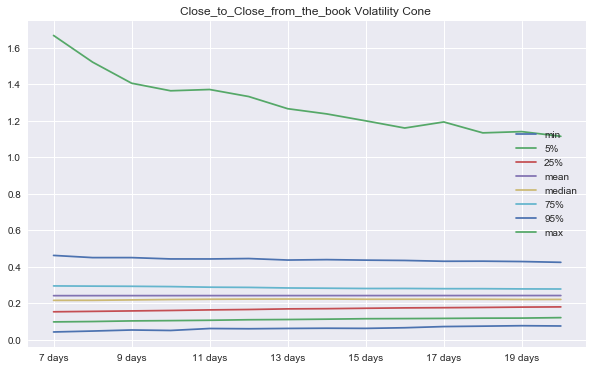

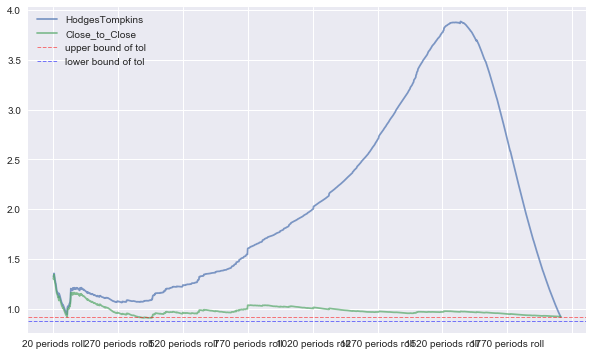

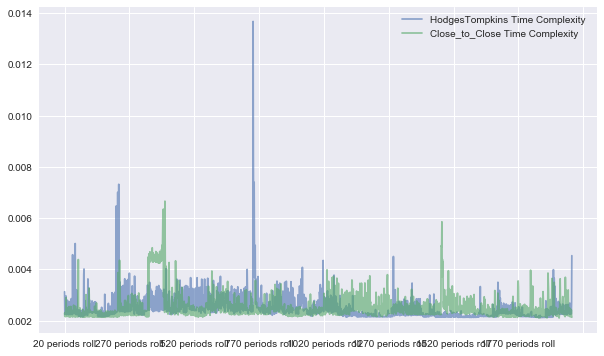

The iteration times of count are 1957 for HodgesTompkins and the periods for it to converge is 1976 and the periods within the bound is 7 
The iteration times of count are 54 for Close_to_Close and the periods for it to converge is 73 and the periods within the bound is 309 


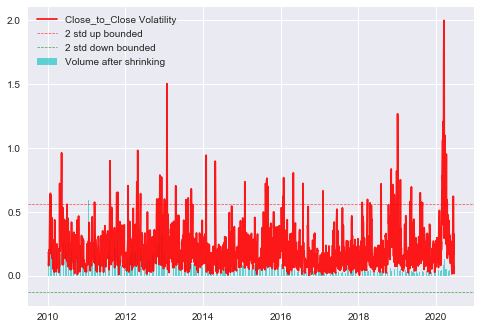

<Figure size 1440x720 with 0 Axes>

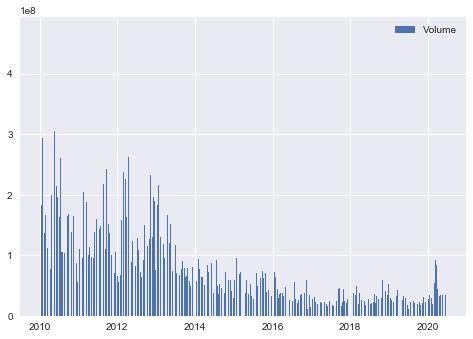

<Figure size 1440x720 with 0 Axes>

In [27]:
if __name__ == '__main__':
    with pd.HDFStore('static_data_AAPL.h5') as hdf:
        print(hdf.keys())
    a=pd.read_hdf("static_data_AAPL.h5",key='/underlying')
    a=a.rename(columns={"adjClose":"Adj Close","adjVolume":"Volume"})
    a=a.rename(columns={"adjHigh":"High","adjLow":"Low","adjOpen":"Open"})
    option_a = Option(a)
    #option_a.Zhang_Yang().plot(figsize=(10,6),label="ZY")
    #option_a.Garman_Klass().plot(figsize=(10,6),label="GK")
    #option_a.RSY().plot()
    #option_a.Zhang_Yang_from_book().plot(label="ZY from Book")
    #option_a.HodgesTompkins().plot(figsize=(10,6),label="HT")
    #option_a.Close_to_Close().plot(figsize=(10,6),label="CC")
    #Parkinson(a,30,252)
    #option_a.Parkinson().plot(figsize=(10,6),label="PK")
    #option_a.Close_to_Close().plot(label="CCB")
    #plt.legend(loc="best")
    #Option(a).Volatility_Cone(Option(a).Zhang_Yang,7,20)
    option_a.Volatility_Cone(option_a.Close_to_Close_from_the_book,7,20)
    Option(a).Time_Complexity([Option(a).HodgesTompkins,Option(a).Close_to_Close],20)
    Vol=Option(a).Volumn_Volatility(Option(a).Close_to_Close,2)
    #Option(a).Volumn_Volatility(Option(a).Close_to_Close,25).iloc[:,0][Option(a).Volumn_Volatility(Option(a).Close_to_Close,25)["Unbounded Check"]==True]
    # Volatility values for the unbouded area

# Implied Volatility

## Data Analysis

In [12]:
a=pd.read_hdf("static_data_AAPL.h5",key='/underlying')
a=a.rename(columns={"adjClose":"Adj Close","adjVolume":"Volume"})
a=a.rename(columns={"adjHigh":"High","adjLow":"Low","adjOpen":"Open"})
option_a = Option(a)
options=pd.read_hdf("static_data_AAPL.h5",key='/options')
options.head(5)
option=options.copy()
option["expdate"]=option["expdate"].apply(lambda x:datetime.date(int(str(x)[0:4]),int(str(x)[4:6]),int(str(x)[6:8])))
option["date"]=option["date"].apply(lambda x:datetime.date(int(str(x)[0:4]),int(str(x)[4:6]),int(str(x)[6:8])))
(option["expdate"][6], option["date"][10000])
option["TTM"]=option["expdate"]-option["date"]
option["TTM"]=option["TTM"].apply(lambda x:x.days)
option=option.drop(["id"],axis=1)
option.drop_duplicates(inplace=True)
result=[]
for i in range(len(a.index)):
    x=datetime.datetime.fromtimestamp(datetime.datetime.timestamp(a.index[i])).strftime('%Y-%m-%d')
    y=datetime.date(int(x[:4]),int(x[5:7]),int(x[8:10]))
    result.append(y)
a.index=result
a.index.name="expdate"
option_price=pd.merge(option,a[["Adj Close","Volume"]],on="expdate",how="left")
option_price=option_price.rename({"Adj Close":"Underlying Price","Volume_y":"Underlying Volume"},axis=1)
col=option_price.columns.tolist()
col[4],col[5],col[6:]=col[-2],col[-1],col[4:-2]
option_price=option_price[col]
option_price.insert(6,"In/Out of Money",0)
option_price["In/Out of Money"]=np.where(((option_price["Call/Put"]=="Call")&(option_price["Underlying Price"]>option_price["strike"]))|((option_price["Call/Put"]=="Put")&(option_price["Underlying Price"]<option_price["strike"])),1,-1)

In [13]:
One_Y_TR=pd.read_csv("1YearTR.csv",skiprows=15,index_col=0)
re=[]
for j in One_Y_TR.index:
    try:
        i=j.split("-")
        re.append(datetime.date(int(i[0]),int(i[1]),int(i[2])))
    except:
        raise
One_Y_TR.index=re
One_Y_TR.dropna(axis=0,inplace=True)
One_Y_TR.columns=["Value"]

## Plot and Calculation

In [41]:
# Assume data is clean
class Implied_Vol_Option():
    def __init__(self,option):
        self.option=option
    def Data_Cleaning(self):
        # No need to do it here, just incase don't get the clues
        options=pd.read_hdf("static_data_AAPL.h5",key='/options')
        option=options.copy()
        option["expdate"]=option["expdate"].apply(lambda x:datetime.date(int(str(x)[0:4]),int(str(x)[4:6]),int(str(x)[6:8])))
        option["date"]=option["date"].apply(lambda x:datetime.date(int(str(x)[0:4]),int(str(x)[4:6]),int(str(x)[6:8])))
        (option["expdate"][6], option["date"][10000])
        option["TTM"]=option["expdate"]-option["date"]
        option["TTM"]=option["TTM"].apply(lambda x:x.days)
        option.drop_duplicates(inplace=True)
        return option
    def Date_to_View(self):
        option=self.option
        # Build the Hashmap for OOP
        Date=defaultdict(list)
        for i in option["date"].unique():
            for j in option[option["date"]==i]["expdate"].unique():
                Date[i].append(j)
        Date_to_View=pd.DataFrame.from_dict(Date,orient="index")
        Date_to_View.columns=["Expdate "+str(i) for i in range(1,20)]
        return Date_to_View
    def Implied_Vol_Smile(self):
        datex=str(input("Please input Year, Month, Day for Option date issued: (eg. formate should be 2001-08-02 for Y-M-D) "))
        date=datex.split("-")
        datey=str(input("Please input Year, Month, Day for Expiration Date issued: (eg. formate should be 2001-08-02 for Y-M-D) "))
        date2=datey.split("-")
        CP=str(input("Please input the types of option to view: Put or Call (Format should be Call or Put or Call,Put with no space)"))
        CP=CP.split(",")
        print(CP)
        option=self.option
        if len(CP)==1:
            plt.figure(figsize=(6,6))
            optout=option[(option.date==datetime.date(int(date[0]),int(date[1]),int(date[2])))&(option.expdate==datetime.date(int(date2[0]),int(date2[1]),int(date2[2])))&(option["Call/Put"]==CP[0])]
            #optin=option[(option.date==datetime.date(int(date[0]),int(date[1]),int(date[2])))&(option.expdate==datetime.date(int(date2[0]),int(date2[1]),int(date2[2])))&(option["Call/Put"]==CP[0])&(option_price["In/Out of Money"]==1)]
            if len(optout)==0:
                return "The {0} Option of this date doesn't exist".format(CP[0])
            label=optin.iloc[0]["Symbol"][0:optin.iloc[0]["Symbol"].find(" ")]
            #plt.plot(optin["strike"],optin["IV"],label="Implied Volatility Smile for {0} in the money".format(CP))
            plt.plot(optout["strike"],optout["IV"],label="Implied Volatility Smile for {0}".format(CP))
            plt.legend(loc='best', bbox_to_anchor=(0.0, 1.10))
            plt.xlabel("Strike Price")
            plt.ylabel("Implied Volatility")
            plt.title("Implied Volatility Smile from {0} to expdate {1} for {2}".format(datex,datey,label))
            plt.show()
        elif len(CP)>1:
            plt.figure(figsize=(6,6))
            optout=option[(option.date==datetime.date(int(date[0]),int(date[1]),int(date[2])))&(option.expdate==datetime.date(int(date2[0]),int(date2[1]),int(date2[2])))&(option["Call/Put"]==CP[0])]
            #optin=option[(option.date==datetime.date(int(date[0]),int(date[1]),int(date[2])))&(option.expdate==datetime.date(int(date2[0]),int(date2[1]),int(date2[2])))&(option["Call/Put"]==CP[0])&(option_price["In/Out of Money"]==1)]
            opt2out=option[(option.date==datetime.date(int(date[0]),int(date[1]),int(date[2])))&(option.expdate==datetime.date(int(date2[0]),int(date2[1]),int(date2[2])))&(option["Call/Put"]==CP[1])]
            #opt2in=option[(option.date==datetime.date(int(date[0]),int(date[1]),int(date[2])))&(option.expdate==datetime.date(int(date2[0]),int(date2[1]),int(date2[2])))&(option["Call/Put"]==CP[1])&(option_price["In/Out of Money"]==1)]
            if len(optout)==0:
                print("The {0} Option of this date doesn't exist".format(CP[0]))
            if len(opt2out)==0:
                print("The {0} Option of this date doesn't exist".format(CP[1]))
            try:
                labels=optout.iloc[0]["Symbol"][0:optout.iloc[0]["Symbol"].find(" ")]
            except:
                labels=opt2out.iloc[0]["Symbol"][0:opt2out.iloc[0]["Symbol"].find(" ")]
            plt.plot(optout["strike"],optout["IV"],label="Implied Volatility Smile for {0} ".format(CP[0]))
            #plt.plot(optout["strike"],optout["IV"],label="Implied Volatility Smile for {0} out the money".format(CP[0]))
            plt.plot(opt2out["strike"],opt2out["IV"],label="Implied Volatility Smile for {0} ".format(CP[1]))
            #plt.plot(opt2out["strike"],opt2out["IV"],label="Implied Volatility Smile for {0} in the money".format(CP[1]))
            plt.legend(loc='best', bbox_to_anchor=(0.0, 1.10))
            plt.xlabel("Strike Price")
            plt.ylabel("Implied Volatility")
            plt.title("Implied Volatility Smile from {0} to expdate {1} for {2}".format(datex,datey,labels))
            plt.show()  
    # From Github and Thanks to Michelle Lin for the help with this code as I just simplify and truncate some parts
    def Implied_Volatility_Surface(self):
        option=self.option
        datex=str(input("Please input the Date to check for Implied Volatility Surface (format is like 2001-08-02) "))
        date=datex.split("-")
        CP=str(input("Please input the Call or Put for Implied Volatility Surface (format is Call or Put)"))
        CP=CP.split(",")
        while len(CP)!=1:
            CP=str(input("Please input again the Call or Put for Implied Volatility Surface (format is Call or Put)"))
            CP=CP.split(",")
        opt=option[(option.date==datetime.date(int(date[0]),int(date[1]),int(date[2])))&(option["Call/Put"]==CP[0])]
        if len(opt)==0:
            labels=" "
            return "For the date {0}, this stock doesn't have {1} option data".format(datex, CP[0])
        else:
            labels=opt.iloc[0]["Symbol"][:opt.iloc[0]["Symbol"].find(" ")]
        TTM,strike,IV=opt["TTM"],opt["strike"],opt["IV"]
        fig1= plt.figure()
        ax1 = fig1.add_subplot(121)
        fig2=plt.figure()
        ax2=fig2.add_subplot(122)
        ax1 = Axes3D(fig1, azim = -30, elev = 52)
        ax2=Axes3D(fig2, azim = -30, elev = 52)
        # Set up the range of the X and Y 
        # meshgrid is used for the grid like matrix for x and y
        TTMx, strikex = np.meshgrid(np.linspace(min(TTM),max(TTM),400),np.linspace(min(strike),max(strike),400))
        IVx = griddata(np.array([TTM,strike]).T,np.array(IV),(TTMx,strikex),method="linear")
        plt.title("Implied Volatility Dot for stock {0} \n Date: {1}".format(labels,datex))
        ax1.plot_surface(TTMx,strikex,IVx,color="b")
        ax1.contour(TTMx,strikex,IVx)
        ax2.plot(TTM, strike, IV,"o")
        plt.xlabel("Time to Expiration")
        plt.ylabel("Strike Price")
        plt.show()
    def Profit_Loss(self,stock, interest_rate):
        # Assume 100 shares per contract
        option=self.option
        start_=str(input("Please input the start date of the option (format is like 2016-09-01)"))
        start=start_.split("-")
        end_=str(input("Please input the end date of the option (format is like 2016-09-01)"))
        end=end_.split("-")
        CP=str(input("Please input option type (format is Call or Put)"))
        shares=int(input("Please input the number of contracts to buy (integer): "))
        money=float(input("Please input the capital prepared for option trading?"))
        option_=option[(option.date==datetime.date(int(start[0]),int(start[1]),int(start[2])))&(option.expdate==datetime.date(int(end[0]),int(end[1]),int(end[2])))&(option["Call/Put"]==CP)]
        if len(option_)==0:
            return "The option that you input doesn't have data"
        print(option_["strike"].values)
        strike=float(input("Please choose the following valid strike price to check Profit and Loss: "))
        while strike not in option_["strike"].values:
            strike=str(input("Please again choose the following valid strike price to check Profit and Loss: "))
        value=option[(option.date==datetime.date(int(start[0]),int(start[1]),int(start[2])))&(option.expdate==datetime.date(int(end[0]),int(end[1]),int(end[2])))&(option["Call/Put"]==CP)&(option["strike"]==strike)]["Option Value"].values
        price=stock[(stock.index>=datetime.date(int(start[0]),int(start[1]),int(start[2])))&(stock.index<=datetime.date(int(end[0]),int(end[1]),int(end[2])))]["Adj Close"]
        result=[]
        ir=interest_rate[(interest_rate.index>=datetime.date(int(start[0]),int(start[1]),int(start[2])))&(interest_rate.index<=datetime.date(int(end[0]),int(end[1]),int(end[2])))]
        interest_rate=pd.merge(price,ir,left_index=True,right_index=True,how="left")
        interest_rate=interest_rate.interpolate(method="linear")
        interest_rate=interest_rate["Value"]
        len_=len(price)
        sum1=1
        if CP=="Call":
            maxx=lambda s,k:max(s-k,0)
        elif CP=="Put":
            maxx=lambda s,k:max(k-s,0)
        # The Dynamic interest rate tracking and iteration
        for i,j in zip(price.values,interest_rate.values):
            sum1=sum1*(1+j/100)**(1/len_)
            max1=maxx(i,strike)
            t=[max1,(max1*100*shares-value*sum1*100*shares)[0],(money+(max1*100*shares-value*sum1*100*shares))[0]]
            result.append(t)
        result=pd.DataFrame(result,index=price.index, columns=["Option Payoff","Option Profit and Loss","Dynamic Money Management"])
        fig=plt.figure(figsize=(15,7))
        ax=fig.add_subplot(131)
        ax.plot(result["Option Payoff"],label="Option Payoff",ls="--",c="r")
        ax.legend(loc="best")
        ax=fig.add_subplot(132)
        ax.plot(result["Option Profit and Loss"],label="Option Profit and Loss")
        ax.legend(loc="best")
        ax=fig.add_subplot(133)
        ax.plot(result["Dynamic Money Management"],label="Dynamic Money Management")
        ax.legend(loc="best")
        return result  

## Hashmap Date and Exp Date Building

In [19]:
Date=defaultdict(list)
for i in option["date"].unique():
    for j in option[option["date"]==i]["expdate"].unique():
        Date[i].append(j)
Date_to_View=pd.DataFrame.from_dict(Date,orient="index")
Date_to_View.columns=["Expdate "+str(i) for i in range(1,20)]

In [21]:
Date_to_View

,Expdate 1,Expdate 2,Expdate 3,Expdate 4,Expdate 5,Expdate 6,Expdate 7,Expdate 8,Expdate 9,Expdate 10,Expdate 11,Expdate 12,Expdate 13,Expdate 14,Expdate 15,Expdate 16,Expdate 17,Expdate 18,Expdate 19
2016-08-19,2016-08-19,2016-08-26,2016-09-02,2016-09-09,2016-09-16,2016-09-23,2016-09-30,2016-10-21,2016-11-18,2016-12-16,2017-01-20,2017-03-17,2017-04-21,2017-06-16,2017-11-17,2018-01-19,None,None,None
2016-08-22,2016-08-26,2016-09-02,2016-09-09,2016-09-16,2016-09-23,2016-09-30,2016-10-21,2016-11-18,2016-12-16,2017-01-20,2017-03-17,2017-04-21,2017-06-16,2017-11-17,2018-01-19,None,None,None,None
2016-08-23,2016-08-26,2016-09-02,2016-09-09,2016-09-16,2016-09-23,2016-09-30,2016-10-21,2016-11-18,2016-12-16,2017-01-20,2017-03-17,2017-04-21,2017-06-16,2017-11-17,2018-01-19,None,None,None,None
2016-08-24,2016-08-26,2016-09-02,2016-09-09,2016-09-16,2016-09-23,2016-09-30,2016-10-21,2016-11-18,2016-12-16,2017-01-20,2017-03-17,2017-04-21,2017-06-16,2017-11-17,2018-01-19,None,None,None,None
1900-01-01,2016-08-26,2016-09-02,2016-09-09,2016-09-16,2016-09-23,2016-09-30,2016-10-21,2016-11-18,2016-12-16,2017-01-20,2017-03-17,2017-04-21,2017-06-16,2017-11-17,2018-01-19,2016-10-07,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-08,2020-06-12,2020-06-19,2020-06-26,2020-07-02,2020-07-10,2020-07-17,2020-07-24,2020-08-21,2020-09-18,2020-10-16,2020-11-20,2020-12-18,2021-01-15,2021-06-18,2021-09-17,2022-01-21,2022-06-17,2022-09-16,None
2020-06-09,2020-06-12,2020-06-19,2020-06-26,2020-07-02,2020-07-10,2020-07-17,2020-07-24,2020-08-21,2020-09-18,2020-10-16,2020-11-20,2020-12-18,2021-01-15,2021-06-18,2021-09-17,2022-01-21,2022-06-17,2022-09-16,None
2020-06-10,2020-06-12,2020-06-19,2020-06-26,2020-07-02,2020-07-10,2020-07-17,2020-07-24,2020-08-21,2020-09-18,2020-10-16,2020-11-20,2020-12-18,2021-01-15,2021-06-18,2021-09-17,2022-01-21,2022-06-17,2022-09-16,None
2020-06-11,2020-06-12,2020-06-19,2020-06-26,2020-07-02,2020-07-10,2020-07-17,2020-07-24,2020-07-31,2020-08-21,2020-09-18,2020-10-16,2020-11-20,2020-12-18,2021-01-15,2021-06-18,2021-09-17,2022-01-21,2022-06-17,2022-09-16


Please input Year, Month, Day for Option date issued: (eg. formate should be 2001-08-02 for Y-M-D) 2016-08-19
Please input Year, Month, Day for Expiration Date issued: (eg. formate should be 2001-08-02 for Y-M-D) 2017-03-17
Please input the types of option to view: Put or Call (Format should be Call or Put or Call,Put with no space)Call,Put
['Call', 'Put']


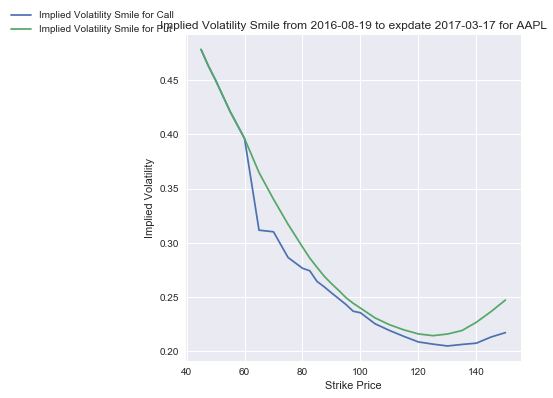

In [42]:
Implied_Vol_Option(option).Implied_Vol_Smile()

Please input the Date to check for Implied Volatility Surface (format is like 2001-08-02) 2020-06-10
Please input the Call or Put for Implied Volatility Surface (format is Call or Put)Put


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: Z contains NaN values. This may result in rendering artifacts.


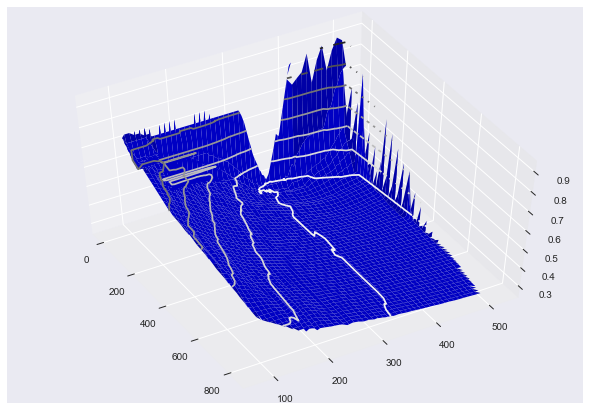

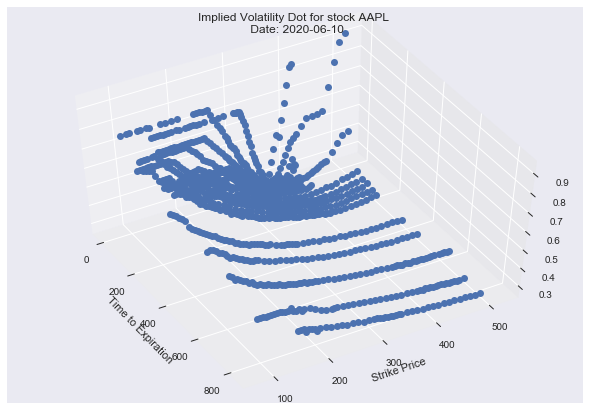

In [45]:
Implied_Vol_Option(option).Implied_Volatility_Surface()